# Prepare labelled input for the NN
# (i.e. locations where moss&lichen fractional cover changed and related meteorological parameters from ERA5-Land)

# Copernicus Global Land Cover data  from 2015-01-01 to 2019-12-31 already available as a netCDF file stored on EOSC (CESNET)
## Troms og Finnmark
### Mosses and lichens, bare, grass, shrubs and trees

In [1]:
!date

Mon Feb 27 13:38:32 UTC 2023


In [2]:
pip install vaex

Note: you may need to restart the kernel to use updated packages.


### Define s3 storage parameters

In [3]:
import s3fs
import xarray as xr
import pandas as pd
import h3
import vaex

In [4]:
client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
store = s3fs.S3FileSystem(anon=False, client_kwargs=client_kwargs)
store.ls('Data', detail=True, refresh=True)

[{'Key': 'Data/C_GlobalLandCover_20150101_20190101_Troms-Finnmark.nc',
  'LastModified': datetime.datetime(2023, 2, 1, 12, 44, 42, 95000, tzinfo=tzlocal()),
  'ETag': '"70e848cfeba6b4e2db997b6efb0ad947-8"',
  'Size': 397191332,
  'StorageClass': 'STANDARD',
  'type': 'file',
  'size': 397191332,
  'name': 'Data/C_GlobalLandCover_20150101_20190101_Troms-Finnmark.nc'},
 {'Key': 'Data/reanalysis-era5-land_hourly_2015-01-01_2019-12-31_Troms-Finnmark_T2m-SD-TP.nc',
  'LastModified': datetime.datetime(2023, 2, 1, 9, 53, 15, 635000, tzinfo=tzlocal()),
  'ETag': '"e48be2b71e08b38d296a0ea6db979b09-23"',
  'Size': 1182124070,
  'StorageClass': 'STANDARD',
  'type': 'file',
  'size': 1182124070,
  'name': 'Data/reanalysis-era5-land_hourly_2015-01-01_2019-12-31_Troms-Finnmark_T2m-SD-TP.nc'},
 {'Key': 'Data/reanalysis-era5-single-levels_2015-2019.nc',
  'LastModified': datetime.datetime(2023, 1, 6, 7, 24, 40, 847000, tzinfo=tzlocal()),
  'ETag': '"2582b929cffaa1770daa45a508dc689a-8"',
  'Size': 391

### Define s3 store for the **netCDF file**

In [5]:
s3path = 'Data/C_GlobalLandCover_20150101_20190101_Troms-Finnmark.nc'

In [6]:
GLC_AOI = xr.open_dataset(store.open(s3path))

In [7]:
GLC_AOI

<xarray.Dataset>
Dimensions:                             (t: 5, x: 16709, y: 3064)
Coordinates:
  * t                                   (t) datetime64[ns] 2015-01-01 ... 201...
  * x                                   (x) float64 15.6 15.6 ... 31.06 31.07
  * y                                   (y) float64 71.19 71.19 ... 68.35 68.35
Data variables: (12/17)
    crs                                 |S1 ...
    Discrete_Classification_map         (t, y, x) float32 ...
    Discrete_Classification_proba       (t, y, x) float32 ...
    Forest_Type_layer                   (t, y, x) float32 ...
    Bare_CoverFraction_layer            (t, y, x) float32 ...
    Crops_CoverFraction_layer           (t, y, x) float32 ...
    ...                                  ...
    BuiltUp_CoverFraction_layer         (t, y, x) float32 ...
    PermanentWater_CoverFraction_layer  (t, y, x) float32 ...
    SeasonalWater_CoverFraction_layer   (t, y, x) float32 ...
    DataDensityIndicator                (t, y, x) float32 ...
    Change_Confidence_layer             (t, y, x) float32 ...
    dataMask                            (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [8]:
GLC_AOI = GLC_AOI.rename(x='lon', y='lat', t='time')

In [9]:
# Drop variables not directly of interest here
GLC_AOI = GLC_AOI.drop_vars(['crs',
                             'Crops_CoverFraction_layer',
                             'Discrete_Classification_map', 
                             'Discrete_Classification_proba',
                             'Forest_Type_layer',
                             'Snow_CoverFraction_layer',
                             'BuiltUp_CoverFraction_layer',
                             'PermanentWater_CoverFraction_layer',
                             'SeasonalWater_CoverFraction_layer',
                             'DataDensityIndicator',
                             'Change_Confidence_layer',
                             'dataMask'])

In [10]:
GLC_AOI = GLC_AOI.rename(Bare_CoverFraction_layer = 'Bare',
                         Grass_CoverFraction_layer = 'Grass',
                         MossLichen_CoverFraction_layer = 'Lichen',
                         Shrub_CoverFraction_layer = 'Shrub',
                         Tree_CoverFraction_layer = 'Tree')

In [11]:
GLC_AOI

<xarray.Dataset>
Dimensions:  (time: 5, lon: 16709, lat: 3064)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 ... 2019-01-01
  * lon      (lon) float64 15.6 15.6 15.6 15.6 15.6 ... 31.06 31.06 31.06 31.07
  * lat      (lat) float64 71.19 71.19 71.19 71.18 ... 68.35 68.35 68.35 68.35
Data variables:
    Bare     (time, lat, lon) float32 ...
    Grass    (time, lat, lon) float32 ...
    Lichen   (time, lat, lon) float32 ...
    Shrub    (time, lat, lon) float32 ...
    Tree     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [12]:
# Troms & Finnmark Global Land Cover area
GLC_AOI_min_lon = GLC_AOI.lon.min()
GLC_AOI_max_lon = GLC_AOI.lon.max()
GLC_AOI_min_lat = GLC_AOI.lat.min()
GLC_AOI_max_lat = GLC_AOI.lat.max()
print(GLC_AOI_min_lon, GLC_AOI_max_lon, GLC_AOI_min_lat, GLC_AOI_max_lat)

<xarray.DataArray 'lon' ()>
array(15.5953135) <xarray.DataArray 'lon' ()>
array(31.06568387) <xarray.DataArray 'lat' ()>
array(68.35153628) <xarray.DataArray 'lat' ()>
array(71.18764739)


### The two cells below redefine a very small region for testing purposes only - skip them to keep the whole Troms-finnmark area

In [13]:
# Small region 
Small_AOI_min_lon = 19.65
Small_AOI_max_lon = 19.7
Small_AOI_min_lat = 69.05
Small_AOI_max_lat = 69.1

In [14]:
#df = GLC_AOI.isel(time = 0).sel(lat=slice(Small_AOI_max_lat, Small_AOI_min_lat), lon=slice(Small_AOI_min_lon, Small_AOI_max_lon)).to_dataframe()

In [15]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [16]:
Small_AOI_center = h3.geo_to_h3((Small_AOI_min_lat + Small_AOI_max_lat)/2, (Small_AOI_min_lon +Small_AOI_max_lon)/2, 9) # lat, lng, hex resolution    
m = visualize_hexagons([h3.geo_to_h3(GLC_AOI_min_lat, GLC_AOI_min_lon, 9)], color="red")                                                                                        
m = visualize_hexagons([h3.geo_to_h3(GLC_AOI_max_lat, GLC_AOI_min_lon, 9)], color="red", folium_map=m)                                                                                   
m = visualize_hexagons([h3.geo_to_h3(GLC_AOI_max_lat, GLC_AOI_max_lon, 9)], color="red", folium_map=m)                                                                                
m = visualize_hexagons([h3.geo_to_h3(GLC_AOI_min_lat, GLC_AOI_max_lon, 9)], color="red", folium_map=m)
#m = visualize_hexagons([Small_AOI_center], color="green", folium_map=m) 
display(m)

## Year 2015

In [17]:
GLC_AOI

<xarray.Dataset>
Dimensions:  (time: 5, lon: 16709, lat: 3064)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 ... 2019-01-01
  * lon      (lon) float64 15.6 15.6 15.6 15.6 15.6 ... 31.06 31.06 31.06 31.07
  * lat      (lat) float64 71.19 71.19 71.19 71.18 ... 68.35 68.35 68.35 68.35
Data variables:
    Bare     (time, lat, lon) float32 ...
    Grass    (time, lat, lon) float32 ...
    Lichen   (time, lat, lon) float32 ...
    Shrub    (time, lat, lon) float32 ...
    Tree     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [18]:
df = GLC_AOI.isel(time = 0).to_dataframe()

In [19]:
df = df.reset_index()

In [20]:
df

,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree
0,15.595314,71.187647,2015-01-01,255.0,255.0,255.0,255.0,255.0
1,15.595314,71.186721,2015-01-01,255.0,255.0,255.0,255.0,255.0
2,15.595314,71.185796,2015-01-01,255.0,255.0,255.0,255.0,255.0
3,15.595314,71.184870,2015-01-01,255.0,255.0,255.0,255.0,255.0
4,15.595314,71.183944,2015-01-01,255.0,255.0,255.0,255.0,255.0
...,...,...,...,...,...,...,...,...
51196371,31.065684,68.355240,2015-01-01,NaN,NaN,NaN,NaN,NaN
51196372,31.065684,68.354314,2015-01-01,NaN,NaN,NaN,NaN,NaN
51196373,31.065684,68.353388,2015-01-01,NaN,NaN,NaN,NaN,NaN
51196374,31.065684,68.352462,2015-01-01,NaN,NaN,NaN,NaN,NaN


In [21]:
# Only keep locations where there is some moss & lichen
df = df.loc[(df['Lichen'] > 0) & (df['Lichen'] <= 100)]

In [22]:
df

,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree
2520,15.595314,68.854314,2015-01-01,NaN,41.0,1.0,29.0,29.0
2823,15.595314,68.573759,2015-01-01,20.0,48.0,24.0,8.0,NaN
2826,15.595314,68.570981,2015-01-01,23.0,58.0,19.0,NaN,NaN
2840,15.595314,68.558018,2015-01-01,7.0,58.0,25.0,10.0,NaN
2885,15.595314,68.516351,2015-01-01,35.0,34.0,31.0,NaN,NaN
...,...,...,...,...,...,...,...,...
51191825,31.064758,69.727462,2015-01-01,NaN,62.0,23.0,15.0,NaN
51191827,31.064758,69.725610,2015-01-01,NaN,78.0,4.0,18.0,NaN
51191828,31.064758,69.724684,2015-01-01,NaN,82.0,3.0,15.0,NaN
51191829,31.064758,69.723759,2015-01-01,NaN,97.0,3.0,NaN,NaN


In [23]:
# Replace NaNs by 0
for col in ['Bare', 'Grass', 'Lichen', 'Shrub', 'Tree']:
    print(col)
    df[col] = df[col].fillna(0)

Bare
Grass
Lichen
Shrub
Tree


/tmp/ipykernel_3425/3639820113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(0)


In [24]:
# Calculate total fractional coverage of bare, grass, lichen, shrub and tree (should be 100)
df['Total']  = (df['Bare'] + df['Grass'] + df['Lichen'] + df['Shrub'] + df['Tree'])

/tmp/ipykernel_3425/3097225748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total']  = (df['Bare'] + df['Grass'] + df['Lichen'] + df['Shrub'] + df['Tree'])


In [25]:
df

,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree,Total
2520,15.595314,68.854314,2015-01-01,0.0,41.0,1.0,29.0,29.0,100.0
2823,15.595314,68.573759,2015-01-01,20.0,48.0,24.0,8.0,0.0,100.0
2826,15.595314,68.570981,2015-01-01,23.0,58.0,19.0,0.0,0.0,100.0
2840,15.595314,68.558018,2015-01-01,7.0,58.0,25.0,10.0,0.0,100.0
2885,15.595314,68.516351,2015-01-01,35.0,34.0,31.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...
51191825,31.064758,69.727462,2015-01-01,0.0,62.0,23.0,15.0,0.0,100.0
51191827,31.064758,69.725610,2015-01-01,0.0,78.0,4.0,18.0,0.0,100.0
51191828,31.064758,69.724684,2015-01-01,0.0,82.0,3.0,15.0,0.0,100.0
51191829,31.064758,69.723759,2015-01-01,0.0,97.0,3.0,0.0,0.0,100.0


In [26]:
# Normalize the fractional cover
for col in ['Bare', 'Grass', 'Lichen', 'Shrub', 'Tree']:
    print(col)
    df[col] = df[col] / df['Total']

Bare
Grass
Lichen
Shrub
Tree


/tmp/ipykernel_3425/1332927214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / df['Total']


In [27]:
# Drop the *tot* column
df = df.drop(['Total'], axis=1)

In [28]:
df

,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree
2520,15.595314,68.854314,2015-01-01,0.00,0.41,0.01,0.29,0.29
2823,15.595314,68.573759,2015-01-01,0.20,0.48,0.24,0.08,0.00
2826,15.595314,68.570981,2015-01-01,0.23,0.58,0.19,0.00,0.00
2840,15.595314,68.558018,2015-01-01,0.07,0.58,0.25,0.10,0.00
2885,15.595314,68.516351,2015-01-01,0.35,0.34,0.31,0.00,0.00
...,...,...,...,...,...,...,...,...
51191825,31.064758,69.727462,2015-01-01,0.00,0.62,0.23,0.15,0.00
51191827,31.064758,69.725610,2015-01-01,0.00,0.78,0.04,0.18,0.00
51191828,31.064758,69.724684,2015-01-01,0.00,0.82,0.03,0.15,0.00
51191829,31.064758,69.723759,2015-01-01,0.00,0.97,0.03,0.00,0.00


In [29]:
# Convert to VAEX
dv = vaex.from_pandas(df)

In [30]:
dv

#,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree
0,15.595313502963002,68.8543140557036,2015-01-01 00:00:00.000000000,0.0,0.41,0.01,0.29,0.29
1,15.595313502963002,68.57375850014802,2015-01-01 00:00:00.000000000,0.2,0.48,0.24,0.08,0.0
2,15.595313502963002,68.57098072237025,2015-01-01 00:00:00.000000000,0.23,0.58,0.19,0.0,0.0
3,15.595313502963002,68.55801775940728,2015-01-01 00:00:00.000000000,0.07,0.58,0.25,0.1,0.0
4,15.595313502963002,68.5163510927406,2015-01-01 00:00:00.000000000,0.35,0.34,0.31,0.0,0.0
...,...,...,...,...,...,...,...,...
"335,764",31.064757947408683,69.72746220385181,2015-01-01 00:00:00.000000000,0.0,0.62,0.23,0.15,0.0
"335,765",31.064757947408683,69.72561035199996,2015-01-01 00:00:00.000000000,0.0,0.78,0.04,0.18,0.0
"335,766",31.064757947408683,69.72468442607405,2015-01-01 00:00:00.000000000,0.0,0.82,0.03,0.15,0.0
"335,767",31.064757947408683,69.72375850014812,2015-01-01 00:00:00.000000000,0.0,0.97,0.03,0.0,0.0


In [31]:
# Find the correspondind ERA5-land lat-lon
# Careful with the latitude, in reverse order
ERA5_lon = ((dv.lon - 15.59) / 0.1).astype('int').values
ERA5_lat = 28 - ((dv.lat - 68.35) / 0.1).astype('int').values

In [32]:
dv['ERA5_lon_index'] = ERA5_lon
dv['ERA5_lat_index'] = ERA5_lat

In [33]:
dv

#,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree,ERA5_lon_index,ERA5_lat_index
0,15.595313502963002,68.8543140557036,2015-01-01 00:00:00.000000000,0.0,0.41,0.01,0.29,0.29,0,23
1,15.595313502963002,68.57375850014802,2015-01-01 00:00:00.000000000,0.2,0.48,0.24,0.08,0.0,0,26
2,15.595313502963002,68.57098072237025,2015-01-01 00:00:00.000000000,0.23,0.58,0.19,0.0,0.0,0,26
3,15.595313502963002,68.55801775940728,2015-01-01 00:00:00.000000000,0.07,0.58,0.25,0.1,0.0,0,26
4,15.595313502963002,68.5163510927406,2015-01-01 00:00:00.000000000,0.35,0.34,0.31,0.0,0.0,0,27
...,...,...,...,...,...,...,...,...,...,...
"335,764",31.064757947408683,69.72746220385181,2015-01-01 00:00:00.000000000,0.0,0.62,0.23,0.15,0.0,154,15
"335,765",31.064757947408683,69.72561035199996,2015-01-01 00:00:00.000000000,0.0,0.78,0.04,0.18,0.0,154,15
"335,766",31.064757947408683,69.72468442607405,2015-01-01 00:00:00.000000000,0.0,0.82,0.03,0.15,0.0,154,15
"335,767",31.064757947408683,69.72375850014812,2015-01-01 00:00:00.000000000,0.0,0.97,0.03,0.0,0.0,154,15


# ERA5-land data from 2015-01-01 to 2019-12-31 1 already available as a netCDF file stored on EOSC (CESNET)
## 2m Temperature, Snow depth, Total precipitation

In [34]:
s3path = 'Data/reanalysis-era5-land_hourly_2015-01-01_2019-12-31_Troms-Finnmark_T2m-SD-TP.nc'

In [35]:
ERA5land = xr.open_dataset(store.open(s3path))

In [36]:
ERA5land

<xarray.Dataset>
Dimensions:    (longitude: 155, latitude: 29, time: 43824)
Coordinates:
  * longitude  (longitude) float32 15.59 15.69 15.79 15.89 ... 30.79 30.89 30.99
  * latitude   (latitude) float32 71.15 71.05 70.95 70.85 ... 68.55 68.45 68.35
  * time       (time) datetime64[ns] 2015-01-01 ... 2019-12-31T23:00:00
Data variables:
    sd         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-31 20:28:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Adding columns with the ERA5-land longitude and latitude to dv

In [37]:
dv['ERA5_lon'] = ERA5land.sel(time="2015-01-01").longitude[dv['ERA5_lon_index'].values].values

In [38]:
dv['ERA5_lat'] = ERA5land.sel(time="2015-01-01").latitude[dv['ERA5_lat_index'].values].values

In [39]:
dv

#,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree,ERA5_lon_index,ERA5_lat_index,ERA5_lon,ERA5_lat
0,15.595313502963002,68.8543140557036,2015-01-01 00:00:00.000000000,0.0,0.41,0.01,0.29,0.29,0,23,15.59,68.85
1,15.595313502963002,68.57375850014802,2015-01-01 00:00:00.000000000,0.2,0.48,0.24,0.08,0.0,0,26,15.59,68.55
2,15.595313502963002,68.57098072237025,2015-01-01 00:00:00.000000000,0.23,0.58,0.19,0.0,0.0,0,26,15.59,68.55
3,15.595313502963002,68.55801775940728,2015-01-01 00:00:00.000000000,0.07,0.58,0.25,0.1,0.0,0,26,15.59,68.55
4,15.595313502963002,68.5163510927406,2015-01-01 00:00:00.000000000,0.35,0.34,0.31,0.0,0.0,0,27,15.59,68.45
...,...,...,...,...,...,...,...,...,...,...,...,...
"335,764",31.064757947408683,69.72746220385181,2015-01-01 00:00:00.000000000,0.0,0.62,0.23,0.15,0.0,154,15,30.99,69.65
"335,765",31.064757947408683,69.72561035199996,2015-01-01 00:00:00.000000000,0.0,0.78,0.04,0.18,0.0,154,15,30.99,69.65
"335,766",31.064757947408683,69.72468442607405,2015-01-01 00:00:00.000000000,0.0,0.82,0.03,0.15,0.0,154,15,30.99,69.65
"335,767",31.064757947408683,69.72375850014812,2015-01-01 00:00:00.000000000,0.0,0.97,0.03,0.0,0.0,154,15,30.99,69.65


In [40]:
import numpy as np

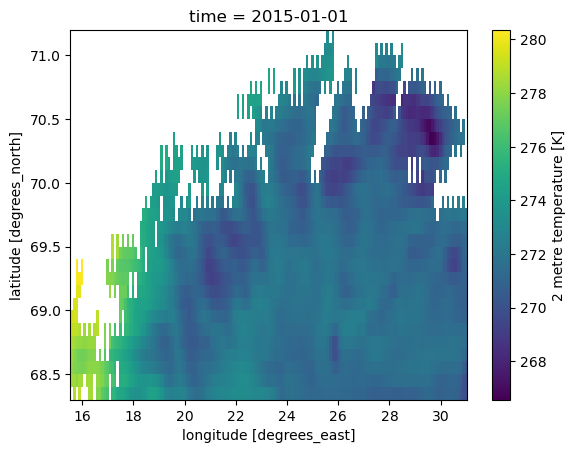

In [41]:
ERA5land.sel(time="2015-01-01").where(ERA5land["latitude"].isin(dv['ERA5_lat'].values) & ERA5land["longitude"].isin(dv['ERA5_lon'].values))["t2m"].isel(time=0).plot()

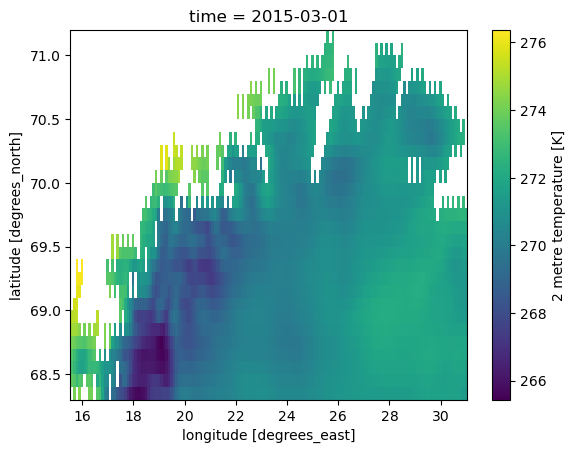

In [42]:
ERA5land.sel(time="2015-03-01").where(ERA5land["latitude"].isin(dv['ERA5_lat'].values) & ERA5land["longitude"].isin(dv['ERA5_lon'].values))["t2m"].isel(time=0).plot()

## Extract ERA5 data for year **2015** and only the first 6 months (when RoS events mostly occur)

In [43]:
ERA5land_2015 = ERA5land.sel(time=slice("2015-01-01", "2015-06-30"))

In [44]:
ERA5land_2015 = ERA5land.sel(time=slice("2015-01-01", "2015-01-01"))

In [45]:
ERA5land_2015

<xarray.Dataset>
Dimensions:    (longitude: 155, latitude: 29, time: 24)
Coordinates:
  * longitude  (longitude) float32 15.59 15.69 15.79 15.89 ... 30.79 30.89 30.99
  * latitude   (latitude) float32 71.15 71.05 70.95 70.85 ... 68.55 68.45 68.35
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-01T23:00:00
Data variables:
    sd         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-31 20:28:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [46]:
era5_field_2015 = ERA5land_2015.where(ERA5land_2015["latitude"].isin(dv['ERA5_lat'].values) & ERA5land_2015["longitude"].isin(dv['ERA5_lon'].values))["t2m"]

In [47]:
era5_field_2015.shape[0]

24

In [48]:
df_2015 = era5_field_2015.stack(z=['latitude', 'longitude']).to_pandas().transpose().reset_index()

In [49]:
df_2015

time,latitude,longitude,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,...,2015-01-01 14:00:00,2015-01-01 15:00:00,2015-01-01 16:00:00,2015-01-01 17:00:00,2015-01-01 18:00:00,2015-01-01 19:00:00,2015-01-01 20:00:00,2015-01-01 21:00:00,2015-01-01 22:00:00,2015-01-01 23:00:00
0,71.150002,15.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71.150002,15.690000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.150002,15.790000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71.150002,15.890000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,71.150002,15.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,68.349998,30.590000,270.859772,270.780396,270.666443,270.462189,270.386444,270.562195,270.882812,270.713715,...,272.291931,272.311340,272.380432,272.223450,271.750122,271.039795,270.484619,269.903381,269.537323,269.291260
4491,68.349998,30.690001,270.667664,270.600983,270.508850,270.319153,270.219757,270.367645,270.695526,270.534332,...,272.125885,272.172546,272.257385,272.126495,271.674347,270.975555,270.406433,269.834900,269.465820,269.222168
4492,68.349998,30.790001,270.387054,270.337341,270.271881,270.100372,269.971893,270.089447,270.420380,270.271881,...,271.871338,271.944061,272.050720,271.951935,271.529510,270.844025,270.280975,269.727020,269.353088,269.112457
4493,68.349998,30.889999,269.932495,269.902191,269.884003,269.751282,269.588837,269.656708,269.966431,269.857941,...,271.445251,271.559814,271.695557,271.652527,271.296753,270.664032,270.147644,269.639160,269.267029,269.028229


In [50]:
df_2015['lat_lon'] = (df_2015['latitude'] * 100).astype('int') + (df_2015['longitude'] * 100).astype('int') / 100000

In [51]:
df_2015

time,latitude,longitude,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,...,2015-01-01 15:00:00,2015-01-01 16:00:00,2015-01-01 17:00:00,2015-01-01 18:00:00,2015-01-01 19:00:00,2015-01-01 20:00:00,2015-01-01 21:00:00,2015-01-01 22:00:00,2015-01-01 23:00:00,lat_lon
0,71.150002,15.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7115.01559
1,71.150002,15.690000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7115.01568
2,71.150002,15.790000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7115.01578
3,71.150002,15.890000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7115.01589
4,71.150002,15.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7115.01598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,68.349998,30.590000,270.859772,270.780396,270.666443,270.462189,270.386444,270.562195,270.882812,270.713715,...,272.311340,272.380432,272.223450,271.750122,271.039795,270.484619,269.903381,269.537323,269.291260,6834.03059
4491,68.349998,30.690001,270.667664,270.600983,270.508850,270.319153,270.219757,270.367645,270.695526,270.534332,...,272.172546,272.257385,272.126495,271.674347,270.975555,270.406433,269.834900,269.465820,269.222168,6834.03069
4492,68.349998,30.790001,270.387054,270.337341,270.271881,270.100372,269.971893,270.089447,270.420380,270.271881,...,271.944061,272.050720,271.951935,271.529510,270.844025,270.280975,269.727020,269.353088,269.112457,6834.03079
4493,68.349998,30.889999,269.932495,269.902191,269.884003,269.751282,269.588837,269.656708,269.966431,269.857941,...,271.559814,271.695557,271.652527,271.296753,270.664032,270.147644,269.639160,269.267029,269.028229,6834.03088


In [52]:
dv['lat_lon'] = (dv['ERA5_lat'] * 100).astype('int') + (dv['ERA5_lon'] * 100).astype('int') / 100000

In [53]:
dv

#,lon,lat,time,Bare,Grass,Lichen,Shrub,Tree,ERA5_lon_index,ERA5_lat_index,ERA5_lon,ERA5_lat,lat_lon
0,15.595313502963002,68.8543140557036,2015-01-01 00:00:00.000000000,0.0,0.41,0.01,0.29,0.29,0,23,15.59,68.85,6885.01559
1,15.595313502963002,68.57375850014802,2015-01-01 00:00:00.000000000,0.2,0.48,0.24,0.08,0.0,0,26,15.59,68.55,6855.01559
2,15.595313502963002,68.57098072237025,2015-01-01 00:00:00.000000000,0.23,0.58,0.19,0.0,0.0,0,26,15.59,68.55,6855.01559
3,15.595313502963002,68.55801775940728,2015-01-01 00:00:00.000000000,0.07,0.58,0.25,0.1,0.0,0,26,15.59,68.55,6855.01559
4,15.595313502963002,68.5163510927406,2015-01-01 00:00:00.000000000,0.35,0.34,0.31,0.0,0.0,0,27,15.59,68.45,6844.01559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"335,764",31.064757947408683,69.72746220385181,2015-01-01 00:00:00.000000000,0.0,0.62,0.23,0.15,0.0,154,15,30.99,69.65,6965.03099
"335,765",31.064757947408683,69.72561035199996,2015-01-01 00:00:00.000000000,0.0,0.78,0.04,0.18,0.0,154,15,30.99,69.65,6965.03099
"335,766",31.064757947408683,69.72468442607405,2015-01-01 00:00:00.000000000,0.0,0.82,0.03,0.15,0.0,154,15,30.99,69.65,6965.03099
"335,767",31.064757947408683,69.72375850014812,2015-01-01 00:00:00.000000000,0.0,0.97,0.03,0.0,0.0,154,15,30.99,69.65,6965.03099


In [54]:
dw = dv.drop(columns=['time'])

## Save into HDF5 both dw and df

In [55]:
type(df)

pandas.core.frame.DataFrame

In [56]:
# Convert to VAEX
#dfv = vaex.from_pandas(df)

In [57]:
#dfv.export_hdf5("ERA5_dfv_dataframe.hdf5")

In [58]:
#dw.export_hdf5("dw_dataframe.hdf5")

In [59]:
dw_pandas = dw.to_pandas_df()

In [60]:
dvw_2015 = dw_pandas.set_index('lat_lon').join(df_2015.set_index('lat_lon'), on='lat_lon')

In [61]:
dvw_2015

,lon,lat,Bare,Grass,Lichen,Shrub,Tree,ERA5_lon_index,ERA5_lat_index,ERA5_lon,...,2015-01-01 14:00:00,2015-01-01 15:00:00,2015-01-01 16:00:00,2015-01-01 17:00:00,2015-01-01 18:00:00,2015-01-01 19:00:00,2015-01-01 20:00:00,2015-01-01 21:00:00,2015-01-01 22:00:00,2015-01-01 23:00:00
lat_lon,,,,,,,,,,,,,,,,,,,,,
6885.01559,15.595314,68.854314,0.00,0.41,0.01,0.29,0.29,0,23,15.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6855.01559,15.595314,68.573759,0.20,0.48,0.24,0.08,0.00,0,26,15.59,...,276.065979,276.094452,276.552673,276.738129,276.704163,276.384155,275.814453,275.387177,275.122314,274.907166
6855.01559,15.595314,68.570981,0.23,0.58,0.19,0.00,0.00,0,26,15.59,...,276.065979,276.094452,276.552673,276.738129,276.704163,276.384155,275.814453,275.387177,275.122314,274.907166
6855.01559,15.595314,68.558018,0.07,0.58,0.25,0.10,0.00,0,26,15.59,...,276.065979,276.094452,276.552673,276.738129,276.704163,276.384155,275.814453,275.387177,275.122314,274.907166
6844.01559,15.595314,68.516351,0.35,0.34,0.31,0.00,0.00,0,27,15.59,...,276.581146,276.677521,277.033875,277.126617,277.199341,276.759338,276.199921,275.850220,275.615662,275.453247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965.03099,31.064758,69.727462,0.00,0.62,0.23,0.15,0.00,154,15,30.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6965.03099,31.064758,69.725610,0.00,0.78,0.04,0.18,0.00,154,15,30.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6965.03099,31.064758,69.724684,0.00,0.82,0.03,0.15,0.00,154,15,30.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Create a land-sea mask
land_sea_mask = ERA5land.sel(time=['2015-01-01T00:00:00.000000000']).squeeze(['time'], drop=True).t2m.notnull()

In [63]:
land_sea_mask

<xarray.DataArray 't2m' (latitude: 29, longitude: 155)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False,  True, False, ...,  True,  True,  True]])
Coordinates:
  * longitude  (longitude) float32 15.59 15.69 15.79 15.89 ... 30.79 30.89 30.99
  * latitude   (latitude) float32 71.15 71.05 70.95 70.85 ... 68.55 68.45 68.35